In [587]:
# Import libraries
import math
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
from sklearn.preprocessing import normalize

In [588]:
# Visualize data in tabular form
df = pd.read_csv('breast-cancer.csv')
df = df.drop(['id'], axis = 1)
df.head()

,diagnosis,radius_mean,texture_mean,perimeter_mean,area_mean,smoothness_mean,compactness_mean,concavity_mean,concave points_mean,symmetry_mean,...,radius_worst,texture_worst,perimeter_worst,area_worst,smoothness_worst,compactness_worst,concavity_worst,concave points_worst,symmetry_worst,fractal_dimension_worst
0,M,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,M,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,M,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,M,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,M,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


In [589]:
df['diagnosis'] = np.where(df['diagnosis'] == 'M', 1, 0)

x_, x_test, y_, y_test = train_test_split(df.drop(columns='diagnosis'), df['diagnosis'], test_size=0.2, random_state=42)
x_train, x_valid, y_train, y_valid = train_test_split(x_, y_, test_size=0.2, random_state=42)

y_valid

95     1
93     0
401    0
345    0
194    1
      ..
71     0
16     1
346    0
149    0
312    0
Name: diagnosis, Length: 91, dtype: int32

For practical use, we will convert the dataframe into a numpy array. Then we will create the functions necessary for logistic regression

In [590]:
x_test = x_test.to_numpy()
x_train = x_train.to_numpy()
x_valid = x_valid.to_numpy()
y_test = y_test.to_numpy()
y_train = y_train.to_numpy()
y_valid = y_valid.to_numpy()

In [591]:
print(x_train.shape)
print(y_train.shape)
print(f"input: \n{x_train}\noutput: \n{y_train}")

(364, 30)
(364,)
input: 
[[1.464e+01 1.524e+01 9.577e+01 ... 1.397e-01 3.151e-01 8.473e-02]
 [1.522e+01 3.062e+01 1.034e+02 ... 2.356e-01 4.089e-01 1.409e-01]
 [1.371e+01 1.868e+01 8.873e+01 ... 1.284e-01 2.849e-01 9.031e-02]
 ...
 [1.270e+01 1.217e+01 8.088e+01 ... 8.224e-02 2.775e-01 9.464e-02]
 [1.460e+01 2.329e+01 9.397e+01 ... 1.359e-01 2.477e-01 6.836e-02]
 [1.267e+01 1.730e+01 8.125e+01 ... 5.602e-02 2.688e-01 6.888e-02]]
output: 
[0 1 0 0 0 0 1 1 0 0 0 0 1 1 1 0 0 0 1 1 0 0 0 0 1 1 0 0 0 0 0 0 0 0 1 0 0
 0 1 0 0 0 1 0 0 0 1 0 0 0 0 1 0 1 0 0 0 0 0 0 1 0 0 0 1 1 0 1 1 0 0 1 0 1
 0 1 1 1 1 0 0 1 0 0 0 0 0 1 1 1 1 0 1 0 0 0 0 0 1 1 0 0 1 0 1 1 0 0 1 0 1
 0 0 0 0 1 0 0 1 0 0 0 0 0 0 1 0 0 1 1 1 0 1 0 1 0 1 1 0 1 0 0 0 0 1 1 1 0
 0 0 1 1 1 0 1 1 1 0 0 1 0 0 0 1 0 0 0 1 0 1 1 1 0 0 1 1 0 1 0 1 1 1 0 0 0
 1 1 0 0 1 1 0 1 0 1 0 0 0 0 0 0 0 0 0 1 0 0 1 1 1 0 0 0 0 1 0 1 1 0 0 0 0
 0 1 0 1 0 0 0 0 0 1 1 1 1 0 0 0 1 1 0 0 1 0 1 1 0 1 1 0 0 0 1 0 0 1 0 1 0
 0 0 0 0 0 0 0 0 1 0 0 0 0 1 1 0 

In [592]:
def sigmoid(z):
    z = z.astype(float)
    return 1/(1+np.exp(-z))

In [593]:
def logistic_cost(w, b, x, y):
    z = np.dot(x, w) + b
    out = np.clip(sigmoid(z), 1e-8, 1-1e-8)
    return np.mean(-y*np.log(out) - (1-y)*np.log(1-out))

In [594]:
def calculate(w, b, x):
    return np.dot(w, x) + b

In [595]:
def batch_training(w, b, x, y, iterations, alpha):

    j_history = []
    m = len(x)
    for i in range(iterations):
        z = np.dot(x, w) + b
        y_pred = sigmoid(z)
        dj_df = (y_pred - y.reshape(-1, 1))/m
        dj_dw = np.dot(np.transpose(x), dj_df)
        dj_db = np.sum(dj_df)
        w -= alpha*dj_dw
        b -= alpha*dj_db

        if i < 100000:
            j_history.append(logistic_cost(w, b, x, y))
        
        if i % (iterations//10) == 0 or i == (iterations-1):
            print(f"Iteration: {i}, Cost: {float(j_history[-1]):.2f}")
            
    return w, b, j_history

In [596]:
weights = 0.001*(np.random.rand(x_train.shape[1], 1) - 0.5)
bias = -5

x_train = normalize(x_train, axis = 0)

In [597]:
j= []
weights, bias, j = batch_training(weights, bias, x_train, y_train, 3000, 0.01)

Iteration: 0, Cost: 1.83
Iteration: 300, Cost: 1.43
Iteration: 600, Cost: 1.08
Iteration: 900, Cost: 0.83
Iteration: 1200, Cost: 0.71
Iteration: 1500, Cost: 0.67
Iteration: 1800, Cost: 0.66
Iteration: 2100, Cost: 0.66
Iteration: 2400, Cost: 0.66
Iteration: 2700, Cost: 0.66
Iteration: 2999, Cost: 0.66


[1.8322637010965892, 1.8308696778031766, 1.8294758550877113, 1.828082233692836, 1.8266888143637372, 1.8252955978481515, 1.8239025848963748, 1.8225097762612676, 1.821117172698262, 1.8197247749653713, 1.8183325838231947, 1.8169406000349242, 1.8155488243663545, 1.8141572575858866, 1.8127659004645384, 1.811374753775949, 1.8099838182963899, 1.8085930948047653, 1.8072025840826274, 1.8058122869141768, 1.8044222040862743, 1.803032336388447, 1.8016426846128926, 1.8002532495544916, 1.7988640320108102, 1.7974750327821098, 1.7960862526713537, 1.7946976924842153, 1.7933093530290827, 1.7919212351170686, 1.790533339562017, 1.78914566718051, 1.7877582187918748, 1.7863709952181912, 1.7849839972842998, 1.7835972258178077, 1.7822106816490961, 1.780824365611331, 1.7794382785404634, 1.7780524212752444, 1.7766667946572274, 1.775281399530776, 1.7738962367430735, 1.7725113071441287, 1.7711266115867836, 1.7697421509267186, 1.7683579260224644, 1.766973937735406, 1.7655901869297874, 1.7642066744727272, 1.7628234

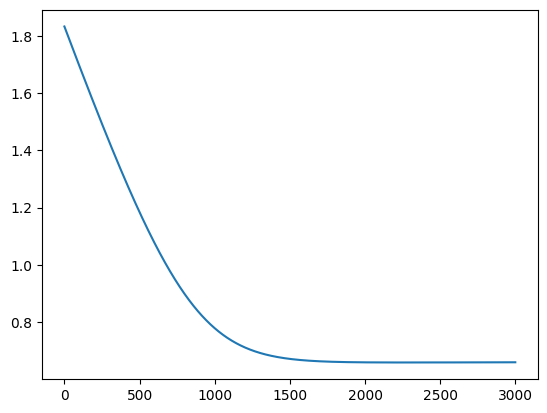

In [598]:
print(j)
plt.plot(j)

In [599]:
x_valid = normalize(x_valid, axis = 0)
z = np.dot(x_valid, weights) + bias
y_pred = sigmoid(z)
print(y_pred)
y_pred = np.round(y_pred)
percent = 0
for i in range(len(y_valid)):
    if y_pred[i,0] == y_valid[i]:
        percent += 1

for i in range(len(y_valid)):
    print(f"prediction:{y_pred[i,0]} vs actual:{y_valid[i]}")

percent /= len(y_valid)
print(percent*100)

[[0.57818118]
 [0.43312874]
 [0.404761  ]
 [0.44083059]
 [0.54030953]
 [0.55101726]
 [0.43101979]
 [0.45314789]
 [0.41914215]
 [0.52270852]
 [0.49784523]
 [0.49625202]
 [0.48370487]
 [0.59565893]
 [0.44896304]
 [0.53307468]
 [0.43299928]
 [0.40329665]
 [0.3812537 ]
 [0.44134142]
 [0.41854271]
 [0.59855345]
 [0.47233619]
 [0.45408864]
 [0.43172614]
 [0.67509134]
 [0.38503687]
 [0.51689892]
 [0.54589217]
 [0.46772581]
 [0.43761931]
 [0.57959304]
 [0.43399893]
 [0.42010542]
 [0.43223846]
 [0.58034457]
 [0.61011132]
 [0.57590313]
 [0.42481446]
 [0.45380454]
 [0.55057649]
 [0.58296828]
 [0.43157853]
 [0.44967337]
 [0.47109418]
 [0.46250192]
 [0.56698317]
 [0.41626544]
 [0.37835108]
 [0.42352835]
 [0.52509081]
 [0.60091264]
 [0.55594474]
 [0.52495809]
 [0.64744594]
 [0.38954855]
 [0.57778399]
 [0.59400248]
 [0.58174588]
 [0.5526448 ]
 [0.49669128]
 [0.60069799]
 [0.40078081]
 [0.45928122]
 [0.42474349]
 [0.5095681 ]
 [0.40504928]
 [0.43354028]
 [0.43306199]
 [0.66591054]
 [0.39393246]
 [0.47